In [1]:
import os
import random
from PIL import Image

from transformers import VisionEncoderDecoderConfig,DonutProcessor, VisionEncoderDecoderModel, BartConfig
from pathlib import Path
import json
from typing import Any, List, Tuple

import torch
from torch.utils.data import Dataset,DataLoader
from datasets import load_dataset

import re
from nltk import edit_distance
import numpy as np
import math

from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import LambdaLR

import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_only

In [2]:
os.environ['HTTP_PROXY']='http://internet.ford.com:83'
os.environ['HTTPS_PROXY']='http://internet.ford.com:83'
os.environ['NO_PROXY']='.ford.com,localhost,127.0.0.0'

In [19]:
!pip install -q pytorch-lightning wandb sentencepiece nltk

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Processor

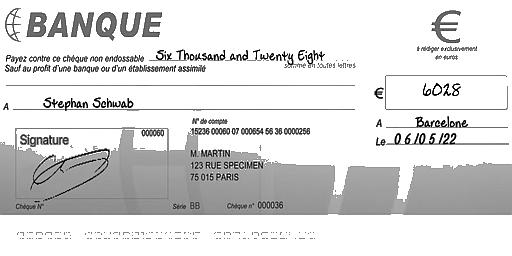

Size :: (512, 256)


In [3]:
# open method used to open different extension image file
num=random.randint(1,10000)

img = Image.open(f"data/images/{num}.jpg") 
  
# This method will show image in any image viewer 
img.show()

print(f"Size :: {img.size}")

In [4]:
max_length = 768
image_size = [320, 480]

# update image_size of the encoder
# during pre-training, a larger image size was used
config = VisionEncoderDecoderConfig.from_pretrained("naver-clova-ix/donut-base")
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length
# TODO we should actually update max_position_embeddings and interpolate the pre-trained ones:
# https://github.com/clovaai/donut/blob/0acc65a85d140852b8d9928565f0f6b2d98dc088/donut/model.py#L602

In [5]:
processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base", config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [6]:
# define paths
base_path = Path("data")
image_path = base_path.joinpath("images")
added_tokens = []

class DonutDataset(Dataset):
    """
    DonutDataset which is saved in huggingface datasets format. (see details in https://huggingface.co/docs/datasets)
    Each row, consists of image path(png/jpg/jpeg) and gt data (json/jsonl/txt),
    and it will be converted into input_tensor(vectorized image) and input_ids(tokenized string).
    Args:
        dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
        max_length: the max number of tokens for the target sequences
        split: whether to load "train", "validation" or "test" split
        ignore_id: ignore_index for torch.nn.CrossEntropyLoss
        task_start_token: the special token to be fed to the decoder to conduct the target task
        prompt_end_token: the special token at the end of the sequences
        sort_json_key: whether or not to sort the JSON keys
    """

    def __init__(
        self,
        dataset_name_or_path: str,
        max_length: int,
        split: str = "train",
        ignore_id: int = -100,
        task_start_token: str = "",
        prompt_end_token: str = None,
        sort_json_key: bool = True,
    ):
        super().__init__()

        self.max_length = max_length
        self.split = split
        self.ignore_id = ignore_id
        self.task_start_token = task_start_token
        self.prompt_end_token = prompt_end_token if prompt_end_token else task_start_token
        self.sort_json_key = sort_json_key

        self.dataset = load_dataset(dataset_name_or_path,data_dir=image_path, split=self.split)
        self.dataset_length = len(self.dataset)

        self.gt_token_sequences = []
        for sample in self.dataset:
            gt_json = sample["text"]

            self.gt_token_sequences.append(
                    self.json2token(
                        gt_json,
                        update_special_tokens_for_json_key=self.split == "train",
                        sort_json_key=self.sort_json_key,
                    )
                    + self.prompt_end_token
            )

        self.add_tokens([self.task_start_token, self.prompt_end_token])
        self.prompt_end_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_end_token)

    def json2token(self, obj: Any, update_special_tokens_for_json_key: bool = True, sort_json_key: bool = True):
        """
        Convert an ordered JSON object into a token sequence
        """
        if type(obj) == dict:
            if len(obj) == 1 and "text_sequence" in obj:
                return obj["text_sequence"]
            else:
                output = ""
                if sort_json_key:
                    keys = sorted(obj.keys(), reverse=True)
                else:
                    keys = obj.keys()
                for k in keys:
                    if update_special_tokens_for_json_key:
                        self.add_tokens([fr"<s_{k}>"]) if fr"<s_{k}>" not in added_tokens else None
                        self.add_tokens([fr"</s_{k}>"]) if fr"</s_{k}>" not in added_tokens else None
                    output += (
                        fr"<s_{k}>"
                        + self.json2token(obj[k], update_special_tokens_for_json_key, sort_json_key)
                        + fr"</s_{k}>"
                    )
                return output
        elif type(obj) == list:
            return r"".join(
                [self.json2token(item, update_special_tokens_for_json_key, sort_json_key) for item in obj]
            )
        else:
            obj = str(obj)
            if f"<{obj}/>" in added_tokens:
                obj = f"<{obj}/>"  # for categorical special tokens
            return obj
    
    def add_tokens(self, list_of_tokens: List[str]):
        """
        Add special tokens to tokenizer and resize the token embeddings of the decoder
        """
        newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
        if newly_added_num > 0:
            model.decoder.resize_token_embeddings(len(processor.tokenizer))
            added_tokens.extend(list_of_tokens)
    
    def __len__(self) -> int:
        return self.dataset_length

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Load image from image_path of given dataset_path and convert into input_tensor and labels
        Convert gt data into input_ids (tokenized string)
        Returns:
            input_tensor : preprocessed image
            input_ids : tokenized gt_data
            labels : masked labels (model doesn't need to predict prompt and pad token)
        """
        sample = self.dataset[idx]
        
        # inputs
        pixel_values = processor(sample["image"].convert('RGB'), random_padding=self.split == "train", return_tensors="pt").pixel_values
        pixel_values = pixel_values.squeeze()

        # targets
        #target_sequence = random.choice(self.gt_token_sequences[idx])  # can be more than one, e.g., DocVQA Task 1
        target_sequence=self.gt_token_sequences[idx]
        input_ids = processor.tokenizer(
            target_sequence,
            add_special_tokens=False,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )["input_ids"].squeeze(0)

        labels = input_ids.clone()
        labels[labels == processor.tokenizer.pad_token_id] = self.ignore_id  # model doesn't need to predict pad token
        # labels[: torch.nonzero(labels == self.prompt_end_token_id).sum() + 1] = self.ignore_id  # model doesn't need to predict prompt (for VQA)
        return pixel_values, labels, target_sequence

In [7]:
# we update some settings which differ from pretraining; namely the size of the images + no rotation required
# source: https://github.com/clovaai/donut/blob/master/config/train_cord.yaml
processor.image_processor.size['width']=image_size[1]
processor.image_processor.size['height']=image_size[0]

#processor.feature_extractor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False

train_dataset = DonutDataset("imagefolder", max_length=max_length,
                             split="train", task_start_token="<s>", prompt_end_token="</s>"
                             )

Resolving data files:   0%|          | 0/10001 [00:00<?, ?it/s]

Using custom data configuration default-b1d3473d18c877cc
Found cached dataset imagefolder (/s/enandhag/.cache/huggingface/datasets/imagefolder/default-b1d3473d18c877cc/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


In [8]:
added_tokens

['<s_VALUE_NUMBERS>',
 '</s_VALUE_NUMBERS>',
 '<s_VALUE_LETTERS>',
 '</s_VALUE_LETTERS>',
 '<s_USER2NAME>',
 '</s_USER2NAME>',
 '<s_BANK_NAME>',
 '</s_BANK_NAME>']

In [9]:
pixel_values, labels, target_sequence = train_dataset[0]

In [10]:
target_sequence

'<s_VALUE_NUMBERS>3755</s_VALUE_NUMBERS><s_VALUE_LETTERS>Three Thousand Seven Hundred and Fifty Five</s_VALUE_LETTERS><s_USER2NAME>Edmee Pelletier</s_USER2NAME><s_BANK_NAME>axis</s_BANK_NAME></s>'

In [11]:
processor.tokenizer.add_special_tokens({"additional_special_tokens": added_tokens})

model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(['<s>'])[0]

In [12]:
processor.tokenizer

PreTrainedTokenizerFast(name_or_path='naver-clova-ix/donut-base', vocab_size=57522, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['<s_VALUE_NUMBERS>', '</s_VALUE_NUMBERS>', '<s_VALUE_LETTERS>', '</s_VALUE_LETTERS>', '<s_USER2NAME>', '</s_USER2NAME>', '<s_BANK_NAME>', '</s_BANK_NAME>']})

In [13]:

# feel free to increase the batch size if you have a lot of memory
# I'm fine-tuning on Colab and given the large image size, batch size > 1 is not feasible
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False, num_workers=4)

In [14]:
batch = next(iter(train_dataloader))
pixel_values, labels, target_sequences = batch
print(pixel_values.shape)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [15]:
class DonutModelPLModule(pl.LightningModule):
    def __init__(self, config, processor, model):
        super().__init__()
        self.config = config
        self.processor = processor
        self.model = model

    def training_step(self, batch, batch_idx):
        pixel_values, labels, _ = batch
        
        outputs = self.model(pixel_values, labels=labels)
        loss = outputs.loss
        self.log_dict({"train_loss": loss}, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx, dataset_idx=0):
        pixel_values, labels, answers = batch
        batch_size = pixel_values.shape[0]
        
        # we feed the prompt to the model
        decoder_input_ids = torch.full((batch_size, 1), self.model.config.decoder_start_token_id, device=self.device)
        
        outputs = self.model.generate(pixel_values,
                                   decoder_input_ids=decoder_input_ids,
                                   max_length=max_length,
                                   early_stopping=True,
                                   pad_token_id=self.processor.tokenizer.pad_token_id,
                                   eos_token_id=self.processor.tokenizer.eos_token_id,
                                   use_cache=True,
                                   num_beams=1,
                                   bad_words_ids=[[self.processor.tokenizer.unk_token_id]],
                                   return_dict_in_generate=True,)
    
        predictions = []
        for seq in self.processor.tokenizer.batch_decode(outputs.sequences):
            seq = seq.replace(self.processor.tokenizer.eos_token, "").replace(self.processor.tokenizer.pad_token, "")
            seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
            predictions.append(seq)

        scores = list()
        for pred, answer in zip(predictions, answers):
            pred = re.sub(r"(?:(?<=>) | (?=</s_))", "", pred)
            answer = answer.replace(self.processor.tokenizer.eos_token, "")
            scores.append(edit_distance(pred, answer) / max(len(pred), len(answer)))

            if self.config.get("verbose", False) and len(scores) == 1:
                print(f"Prediction: {pred}")
                print(f"    Answer: {answer}")
                print(f" Normed ED: {scores[0]}")

        return scores

    def validation_epoch_end(self, validation_step_outputs):
        # I set this to 1 manually
        # (previously set to len(self.config.dataset_name_or_paths))
        num_of_loaders = 1
        if num_of_loaders == 1:
            validation_step_outputs = [validation_step_outputs]
        assert len(validation_step_outputs) == num_of_loaders
        cnt = [0] * num_of_loaders
        total_metric = [0] * num_of_loaders
        val_metric = [0] * num_of_loaders
        for i, results in enumerate(validation_step_outputs):
            for scores in results:
                cnt[i] += len(scores)
                total_metric[i] += np.sum(scores)
            val_metric[i] = total_metric[i] / cnt[i]
            val_metric_name = f"val_metric_{i}th_dataset"
            self.log_dict({val_metric_name: val_metric[i]}, sync_dist=True)
        self.log_dict({"val_metric": np.sum(total_metric) / np.sum(cnt)}, sync_dist=True)

    def configure_optimizers(self):
        # TODO add scheduler
        optimizer = torch.optim.Adam(self.parameters(), lr=self.config.get("lr"))
    
        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

In [16]:
config = {"max_epochs":2,
          "val_check_interval":0.2, # how many times we want to validate during an epoch
          "check_val_every_n_epoch":1,
          "gradient_clip_val":1.0,
          "num_training_samples_per_epoch": 800,
          "lr":3e-5,
          "train_batch_sizes": [8],
          "val_batch_sizes": [1],
          # "seed":2022,
          "num_nodes": 1,
          "warmup_steps": 300, # 800/8*30/10, 10%
          "result_path": "./result",
          "verbose": True,
          }

model_module = DonutModelPLModule(config, processor, model)
     

In [ ]:
trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=config.get("max_epochs"),
        val_check_interval=config.get("val_check_interval"),
        check_val_every_n_epoch=config.get("check_val_every_n_epoch"),
        gradient_clip_val=config.get("gradient_clip_val"),
        precision=16, # we'll use mixed precision
        num_sanity_val_steps=0
)

trainer.fit(model_module)

Validation: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 